# Pokémon type classifier

My son loves to play Pokémon, and occasionally I will play with him. Since I'm an ad-hoc player, I struggle to remember the different types of Pokémon (e.g., Grass, Water, Fighting, etc.).

The purpose of this notebook is to build a deep learning classifier (CNN) to classify Pokemon by type. I am working my way through the **Practical Deep Learning for Coders, v3** class at fast.ai (https://course.fast.ai/), so I'm also learning the fastai library. 

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate
import json
import requests
from PIL import Image

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# Data Acquisition

We will gather metadata about Pokémon cards (i.e., URLs to download content, and Pokémon type) from the PokemonTCG github repository (https://github.com/PokemonTCG).

Then, we will download the images, and crop the art for classification purposes, ignoring the text on the card. 

There are many card sets, so, I picked three sets randomly, hoping that three sets will give us enough image data to train.

In [4]:
!wget 'https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Burning%20Shadows.json'

--2019-07-07 16:07:22--  https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Burning%20Shadows.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199578 (195K) [text/plain]
Saving to: ‘Burning Shadows.json’

Burning Shadows.jso 100%[===================>] 194.90K  --.-KB/s    in 0.04s   

2019-07-07 16:07:22 (5.09 MB/s) - ‘Burning Shadows.json’ saved [199578/199578]



In [5]:
!wget 'https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Evolutions.json'

--2019-07-07 16:07:25--  https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Evolutions.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115198 (112K) [text/plain]
Saving to: ‘Evolutions.json’

Evolutions.json     100%[===================>] 112.50K  --.-KB/s    in 0.04s   

2019-07-07 16:07:25 (2.95 MB/s) - ‘Evolutions.json’ saved [115198/115198]



In [6]:
!wget 'https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Celestial%20Storm.json'

--2019-07-07 16:07:26--  https://raw.githubusercontent.com/PokemonTCG/pokemon-tcg-data/master/json/cards/Celestial%20Storm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 206204 (201K) [text/plain]
Saving to: ‘Celestial Storm.json’

Celestial Storm.jso 100%[===================>] 201.37K  --.-KB/s    in 0.04s   

2019-07-07 16:07:26 (5.24 MB/s) - ‘Celestial Storm.json’ saved [206204/206204]



In [7]:
!ls

'Burning Shadows.json'	'Celestial Storm.json'	 Evolutions.json   sample_data


Now that we've downloaded the JSON files which contain the metadata we need, we will loop through those files to collect the data we need.

1.  ID
2.  Pokemon type
3. URL to download the scan of the playing card
4. Set code (to differentiate the filenames)

In [0]:
ids = []
types = []
urls = []
setcodes = []

for f in ['Burning Shadows.json', 'Evolutions.json', 'Celestial Storm.json']:
  with open(f) as json_file:
    data = json.load(json_file)
    for item in data:
      if item['supertype'] in ('Pokémon'):
        # print(item['id'], item['types'], item['imageUrlHiRes'])
        setcodes.append(item['setCode'])
        ids.append(item['id'])
        types.append(item['types'][0])
        urls.append(item['imageUrlHiRes'])
    

In [9]:
# for ease, let's load these into a pandas.DataFrame
df = pd.DataFrame({'setcode': setcodes, 'id': ids, 'types': types, 'urls': urls})
df.head()

,setcode,id,types,urls
0,sm3,sm3-1,Grass,https://images.pokemontcg.io/sm3/1_hires.png
1,sm3,sm3-2,Grass,https://images.pokemontcg.io/sm3/2_hires.png
2,sm3,sm3-3,Grass,https://images.pokemontcg.io/sm3/3_hires.png
3,sm3,sm3-4,Grass,https://images.pokemontcg.io/sm3/4_hires.png
4,sm3,sm3-5,Grass,https://images.pokemontcg.io/sm3/5_hires.png


In [10]:
# how many cards?
len(df)

360

What is our distribution of Pokemon types?

In [11]:
df.types.value_counts()

Grass        55
Psychic      49
Water        48
Fighting     45
Colorless    37
Fire         36
Lightning    29
Darkness     19
Metal        18
Dragon       13
Fairy        11
Name: types, dtype: int64

In [12]:
# get unique Pokemon types
classes = df.types.unique()
classes

array(['Grass', 'Fire', 'Water', 'Lightning', 'Psychic', 'Fighting', 'Darkness', 'Fairy', 'Dragon', 'Colorless',
       'Metal'], dtype=object)

In [0]:
# let's make subdirectories for each Pokemon type to later put the images there,
# sorted by type
!rm -rf rawimage
!mkdir rawimage
for item in classes:
  !mkdir rawimage/{item}

In [0]:
# download the images into each class (i.e. type) subdirectory
for index, row in df.iterrows():
  pokemon_type = row.types
  url = row.urls
  setcode = row.setcode
  filename = url.split('/')[-1]
  with open('rawimage/{0}/{1}-{2}'.format(pokemon_type, setcode, filename), 'wb') as fh:
    fh.write(requests.get(url).content)
    

In [0]:
# put cropped images here
!rm -rf croppedimage
!mkdir croppedimage
for item in classes:
  !mkdir croppedimage/{item}

In [16]:
folders = os.listdir('rawimage')
folders

['Lightning',
 'Grass',
 'Colorless',
 'Psychic',
 'Fighting',
 'Water',
 'Fire',
 'Fairy',
 'Dragon',
 'Metal',
 'Darkness']

For each card, we will crop to the upper right corner to capture the symbol for Pokémon type.

In [0]:
# gets upper right corner type symbol
x_start = 620
y_start = 10
x_end = x_start + 70
y_end = y_start + 70

for folder in folders:
  images = os.listdir(os.path.join('rawimage',folder))
  for i in images:
    im = Image.open(os.path.join('rawimage', folder, i))
    imCrop = im.crop((x_start, y_start, x_end, y_end))
    imCrop.save(os.path.join('croppedimage', folder, i))

In [0]:
def construct_filename(row):
  img = row['urls'].split('/')[-1]
  fname = "croppedimage/{0}/{1}-{2}".format(row['types'], row['setcode'], img)
  return fname

df['name'] = df.apply(construct_filename, axis=1)

In [19]:
df.rename(columns={"types": "label"}, inplace=True)
df.head()

,setcode,id,label,urls,name
0,sm3,sm3-1,Grass,https://images.pokemontcg.io/sm3/1_hires.png,croppedimage/Grass/sm3-1_hires.png
1,sm3,sm3-2,Grass,https://images.pokemontcg.io/sm3/2_hires.png,croppedimage/Grass/sm3-2_hires.png
2,sm3,sm3-3,Grass,https://images.pokemontcg.io/sm3/3_hires.png,croppedimage/Grass/sm3-3_hires.png
3,sm3,sm3-4,Grass,https://images.pokemontcg.io/sm3/4_hires.png,croppedimage/Grass/sm3-4_hires.png
4,sm3,sm3-5,Grass,https://images.pokemontcg.io/sm3/5_hires.png,croppedimage/Grass/sm3-5_hires.png


Now we load data into ImageDataBunch class (https://docs.fast.ai/vision.data.html#ImageDataBunch) which gives us lots of convenience.

Since our data is not split into train and valid folders, we let ImageDataBunch do this by passing in a valid_pct argument to give us a 80-20 split.

In [0]:
np.random.seed(42)

# using from_df:
# imgdata = ImageDataBunch.from_df(path='.', df=df[['name', 'label']], ds_tfms=get_transforms(), size=224, valid_pct=0.2)

# using from_folder
path = Path('croppedimage')
imgdata = ImageDataBunch.from_folder(
    path=path, 
    train='.', 
    valid_pct=0.2, 
    ds_tfms=get_transforms(), 
    size=224,
    num_workers=4
).normalize(imagenet_stats)


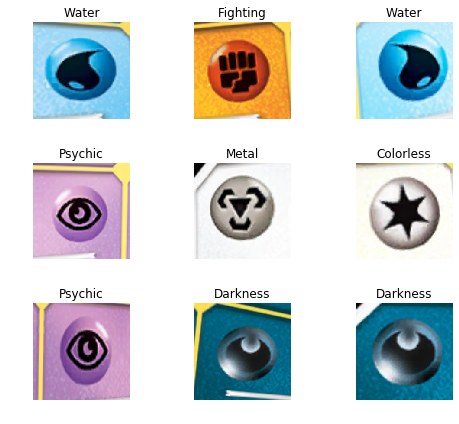

In [21]:
imgdata.show_batch(rows=3, figsize=(7,6))

In [22]:
print(imgdata.classes)
len(imgdata.classes),imgdata.c

['Colorless', 'Darkness', 'Dragon', 'Fairy', 'Fighting', 'Fire', 'Grass', 'Lightning', 'Metal', 'Psychic', 'Water']


(11, 11)

**Training resnet34**

Now to train a CNN using Resnet34 (see: https://www.kaggle.com/pytorch/resnet34 and https://arxiv.org/pdf/1512.03385.pdf).

In [23]:
learn = cnn_learner(imgdata, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 21840504.83it/s]


In [24]:
# describe the model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
# our first attempt, and we use 4 epochs
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.554169,1.631241,0.430556,01:45
1,1.595393,0.585566,0.125000,01:44
2,1.089170,0.252451,0.055556,01:46
3,0.812259,0.151314,0.027778,01:44


In [0]:
learn.save('cropped-stage-1')

# Results

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(imgdata.valid_ds)==len(losses)==len(idxs)

True

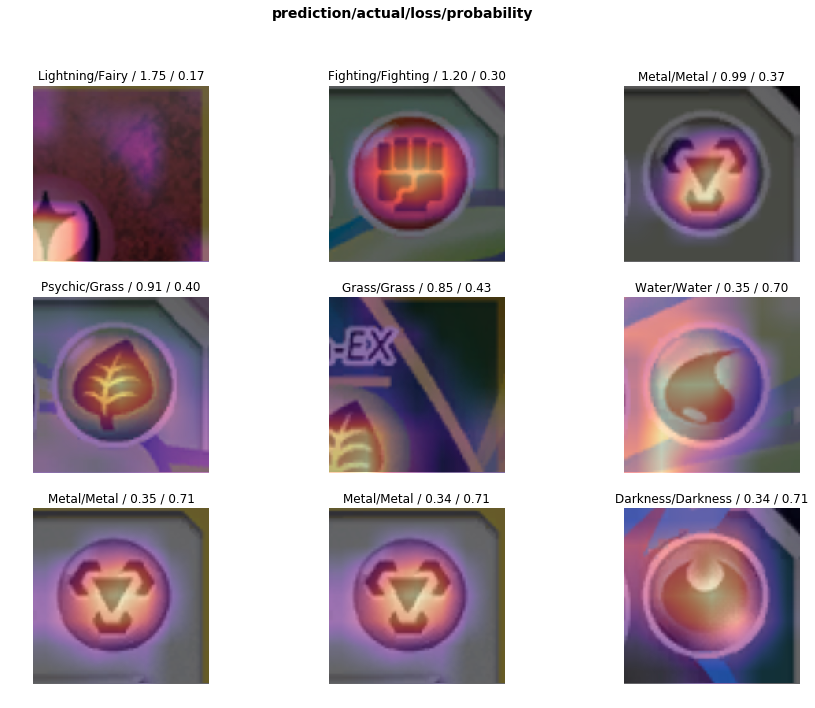

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

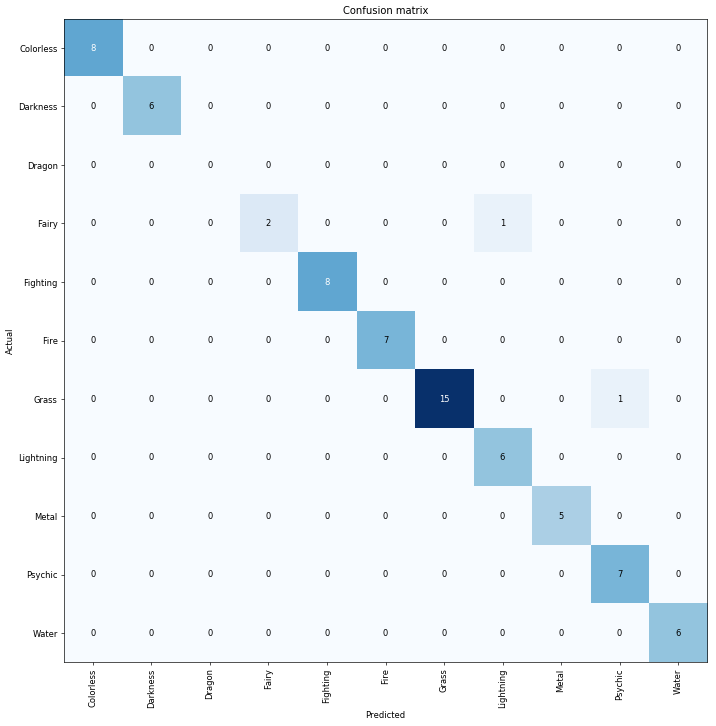

In [29]:
# since we don't have a ton of classes, let's go ahead and plot confusion matrix
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
# should be empty since we had 0 errors
interp.most_confused(min_val=2)

[]

# Unfreezing, fine-tuning, and learning rates

Not sure we will need to do this, but this is what was done in the lesson, might as well try this out.

In [0]:
learn.unfreeze()

In [32]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.116245,0.163159,0.013889,02:25


In [33]:
learn.load('cropped-stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Lightning,Lightning,Lightning,Lightning,Lightning
Path: croppedimage;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Water,Grass,Fire,Fairy,Grass
Path: croppedimage;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


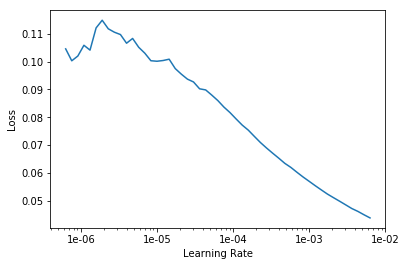

In [35]:
# let's see how we might adjust the learning rate
learn.recorder.plot()

In [36]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.111931,0.083188,0.013889,02:25
1,0.091858,0.053958,0.013889,02:26


In [40]:
learn.data

ImageDataBunch;

Train: LabelList (288 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Lightning,Lightning,Lightning,Lightning,Lightning
Path: croppedimage;

Valid: LabelList (72 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Water,Grass,Fire,Fairy,Grass
Path: croppedimage;

Test: None

In [0]:
learn.save('cropped-stage-2')

In [42]:
!ls -al

total 540
drwxr-xr-x  1 root root   4096 Jul  7 16:14  .
drwxr-xr-x  1 root root   4096 Jul  7 15:50  ..
-rw-r--r--  1 root root 199578 Jul  7 16:07 'Burning Shadows.json'
-rw-r--r--  1 root root 206204 Jul  7 16:07 'Celestial Storm.json'
drwxr-xr-x  1 root root   4096 Jun 26 16:07  .config
drwxr-xr-x 14 root root   4096 Jul  7 16:30  croppedimage
-rw-r--r--  1 root root 115198 Jul  7 16:07  Evolutions.json
drwxr-xr-x 13 root root   4096 Jul  7 16:10  rawimage
drwxr-xr-x  1 root root   4096 Jun 18 16:14  sample_data


# Try training again but use full image
Just because I'm curious what the results would be, if we don't crop but use the entire image from the card. I think by not narrowing our focus to the type symbol, we will get much worse results. But maybe background color will help?

In [49]:
rawdf = df.copy()
rawdf.head()

,setcode,id,label,urls,name
0,sm3,sm3-1,Grass,https://images.pokemontcg.io/sm3/1_hires.png,croppedimage/Grass/sm3-1_hires.png
1,sm3,sm3-2,Grass,https://images.pokemontcg.io/sm3/2_hires.png,croppedimage/Grass/sm3-2_hires.png
2,sm3,sm3-3,Grass,https://images.pokemontcg.io/sm3/3_hires.png,croppedimage/Grass/sm3-3_hires.png
3,sm3,sm3-4,Grass,https://images.pokemontcg.io/sm3/4_hires.png,croppedimage/Grass/sm3-4_hires.png
4,sm3,sm3-5,Grass,https://images.pokemontcg.io/sm3/5_hires.png,croppedimage/Grass/sm3-5_hires.png


In [0]:
def construct_raw_name(row):
  img = row['urls'].split('/')[-1]
  fname = "rawimage/{0}/{1}-{2}".format(row['label'], row['setcode'], img)
  return fname


In [0]:
rawdf['name'] = rawdf.apply(construct_raw_name, axis=1)

In [52]:
rawdf.head()

,setcode,id,label,urls,name
0,sm3,sm3-1,Grass,https://images.pokemontcg.io/sm3/1_hires.png,rawimage/Grass/sm3-1_hires.png
1,sm3,sm3-2,Grass,https://images.pokemontcg.io/sm3/2_hires.png,rawimage/Grass/sm3-2_hires.png
2,sm3,sm3-3,Grass,https://images.pokemontcg.io/sm3/3_hires.png,rawimage/Grass/sm3-3_hires.png
3,sm3,sm3-4,Grass,https://images.pokemontcg.io/sm3/4_hires.png,rawimage/Grass/sm3-4_hires.png
4,sm3,sm3-5,Grass,https://images.pokemontcg.io/sm3/5_hires.png,rawimage/Grass/sm3-5_hires.png


In [0]:
rawimgdata = ImageDataBunch.from_folder(
    path=Path('rawimage'), 
    train='.', 
    valid_pct=0.2, 
    ds_tfms=get_transforms(), 
    size=224,
    num_workers=4
).normalize(imagenet_stats)

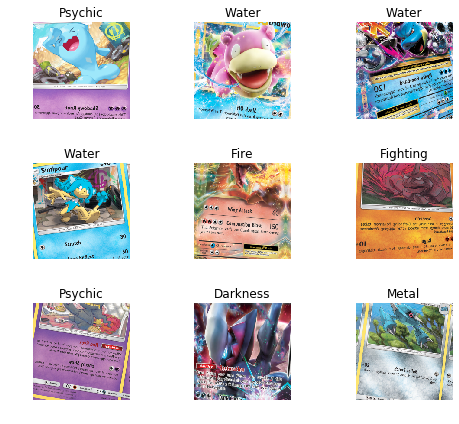

In [54]:
rawimgdata.show_batch(rows=3, figsize=(7,6))

# Train resnet34

In [0]:
rawlearn = cnn_learner(rawimgdata, models.resnet34, metrics=error_rate)

In [56]:
rawlearn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.839681,2.327837,0.833333,02:00
1,2.583754,1.912860,0.652778,02:01
2,2.229330,1.647411,0.569444,02:00
3,1.967845,1.565854,0.513889,02:00


In [57]:
rawlearn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


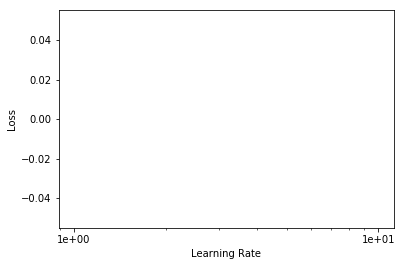

In [61]:
rawlearn.recorder.plot()

In [62]:
rawlearn.unfreeze()
rawlearn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.104316,1.361080,0.458333,02:36
1,1.052368,1.300420,0.402778,02:35
